In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from tensorflow import keras

In [2]:
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

Populating the interactive namespace from numpy and matplotlib


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Input, Dropout, BatchNormalization

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback, LearningRateScheduler

In [10]:
from tensorflow.keras.models import load_model, Model

In [11]:
from tensorflow.keras import regularizers

In [12]:
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [14]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

(Class below comes from: https://stackoverflow.com/questions/67271590/issue-with-custom-metric-auc-callback-for-keras)

In [15]:
# Custom skelearn-based AUROC calculation class for use with the FULL validation 
#   set (not just mini-batches) at the end of each training epoch

class ROAUCMetrics(keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.valid_x = val_data[0]
        self.valid_y = val_data[1]

    def on_train_begin(self, logs={}):
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.valid_x)
        val_auc = roc_auc_score(self.valid_y, pred,  average='micro')
        print('\nval-roc-auc: %s' % (str(round(val_auc,4))),end=100*' '+'\n\n')
        self.val_aucs.append(val_auc)
        return

# 1) Import the data

In [16]:
X_train = np.load('data2/X_train.dat')
y_train = np.load('data2/y_train.dat')

X_val = np.load('data2/X_val.dat')
y_val = np.load('data2/y_val.dat')

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(37469, 224, 273, 1)
(37469, 4)
(8029, 224, 273, 1)
(8029, 4)


In [17]:
y_train = y_train.astype(float)
y_val = y_val.astype(float) 

# 2) Pre-trained Model (VGG16 - all weights frozen)

### Standardize the X Data
(based on https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/)

In [12]:
batch_size = 32

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train, batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val, batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=1171, val=251


In [69]:
from tensorflow.keras.applications import VGG16

# This converts the 1-channel X-rays to 3-channel images a required by mobilenet_v2
input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(3,(3,3),padding='same')(input_tensor)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

out = base_model(x)
new_base_model = Model(inputs=input_tensor, outputs=out)
    
# Establish new fully connected block
x = new_base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(units=128, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(units=64, activation='relu')(x)
predictions = Dense(units=4, activation='sigmoid')(x) # 4 target labels

# define formal model object to train and compile it as usual
model = Model(inputs=new_base_model.input, outputs=predictions)

In [70]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 28672)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               3670144   
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 260 

In [74]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

In [79]:
# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.1, patience=2)

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=6, restore_best_weights=True)

model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=50, verbose=1, validation_data=val_iterator,
       callbacks=[
           auc,
           eval_callback,
           reduce_lr,
           early_stopping,
           keras.callbacks.ModelCheckpoint(
               'models_3/model_4.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])

Epoch 1/50
1171/1171 [==============================] - 8671s 7s/step - loss: 0.5240 - val_loss: 0.4965

val-roc-auc: 0.7366                                                                                                    
Epoch 2/50
1171/1171 [==============================] - 8591s 7s/step - loss: 0.4871 - val_loss: 0.5079

val-roc-auc: 0.7202                                                                                                    
Epoch 3/50
1171/1171 [==============================] - 8515s 7s/step - loss: 0.4704 - val_loss: 0.4997

val-roc-auc: 0.7269                                                                                                    
Epoch 4/50
1171/1171 [==============================] - 8460s 7s/step - loss: 0.4529 - val_loss: 0.4950

val-roc-auc: 0.7205                                                                                                    
Epoch 5/50
1171/1171 [==============================] - 8569s 7s/step - loss: 0.4096 - val_loss: 0.4

KeyboardInterrupt: 

In [13]:
model = load_model('models_3/model_4.01-0.50.hdf5')

y_pred = model.predict(X_val)

roc_auc_score(y_val, y_pred, average='micro')

2022-01-16 17:40:37.332799: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-16 17:40:37.923477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


0.7366070260346703

In [14]:
roc_auc_score(y_val, y_pred, average=None)

array([0.64099609, 0.71990439, 0.71710997, 0.76145158])

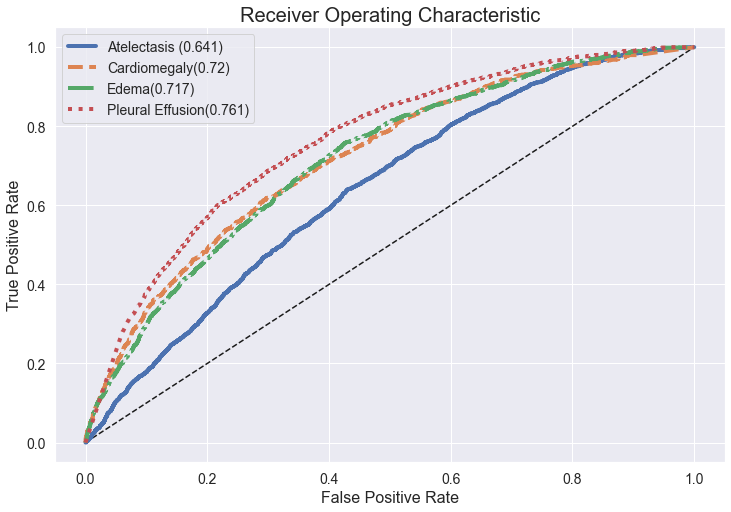

In [73]:
fpr_all_1 , tpr1, thresholds1 = roc_curve(y_val[:, 0], y_pred[:, 0])

fpr_all_2 , tpr2, thresholds2 = roc_curve(y_val[:, 1], y_pred[:, 1])

fpr_all_3 , tpr3, thresholds3 = roc_curve(y_val[:, 2], y_pred[:, 2])

fpr_all_4 , tpr4, thresholds4 = roc_curve(y_val[:, 3], y_pred[:, 3])

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_all_1, tpr1, label= 'Atelectasis ({})'.format(round(auc(fpr_all_1, tpr1), 3)), linewidth=4)
plt.plot(fpr_all_2, tpr2, label= 'Cardiomegaly({})'.format(round(auc(fpr_all_2, tpr2), 3)), linestyle='--', linewidth=4)
plt.plot(fpr_all_3, tpr3, label= 'Edema({})'.format(round(auc(fpr_all_3, tpr3), 3)), linestyle='-.', linewidth=4)
plt.plot(fpr_all_4, tpr4, label= 'Pleural Effusion({})'.format(round(auc(fpr_all_4, tpr4), 3)), linestyle=':', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic', fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

# 3) SINGLE-TARGET MODELS

## 3a) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (Target 0: 'Atelectasis')
#### Dropout = 0.30, l1_reg = 0.00001, l2_reg = 0.0001

In [28]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 0

Class Weighting (below) based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [29]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.52


In [30]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [31]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=147, val=32


In [32]:
keras.backend.clear_session()

## Load model pre-trained on baby dataset (just 985 training images)
model_0 = load_model('models_baby2/model_10.13-0.6911.hdf5')

model_0.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [33]:
model_0.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.000125,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [34]:
model_0.loss

<function tensorflow.python.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)>

In [35]:
# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.6, patience=0, mode='max', min_delta=0.002)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model_0.optimizer.get_config()['learning_rate'], 7))))

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=2, restore_best_weights=True)

history = model_0.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=6, verbose=1, validation_data=val_iterator, 
                   class_weight=class_weights, 
                   callbacks=[
                       auc,
                       eval_callback,
                       reduce_lr,
                       lr_callback,
                       early_stopping,
                       keras.callbacks.ModelCheckpoint(
                           'models_final/model_0.{epoch:02d}-{auc:.4f}.hdf5',
                           save_best_only=False)
                   ])

Epoch 1/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9070s 62s/step - loss: 0.7598 - val_loss: 0.7341

val-roc-auc: 0.6607                                                                                                    

Epoch 2/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9188s 63s/step - loss: 0.7080 - val_loss: 0.6620

val-roc-auc: 0.6724                                                                                                    

Epoch 3/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9089s 62s/step - loss: 0.6822 - val_loss: 0.6774

val-roc-auc: 0.6785                                                                                                    

Epoch 4/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9043s 62s/step - loss: 0.6627 - val_loss: 0.7018

val-roc-auc: 0.6742                                                          

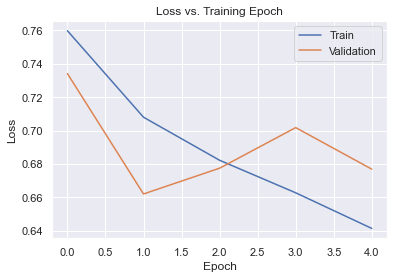

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

### 3b) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (Target 1: 'Cardiomegaly')
#### Dropout = 0.35, l1_reg = 0.00001, l2_reg = 0.0001

In [37]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 1

Class Weighting (below) based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [38]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.59
Weight for class 1: 3.36


In [39]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [40]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=147, val=32


In [41]:
model_1 = load_model('models_baby/model_10.07-0.6224.hdf5')

model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [42]:
model_1.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.00025,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [43]:
initial_learning_rate = 0.000125
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model_1.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [44]:
model_1.optimizer.get_config()['learning_rate']

0.000125

In [45]:
# Decrement learning rate every epoch
def lr_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    a = 0.6
    return lr * a

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.6, patience=1, mode='max', min_delta=0.002, min_lr=1e-7)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model_1.optimizer.get_config()['learning_rate'], 7))))

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=2, restore_best_weights=True)

history_1 = model_1.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=6, verbose=1, validation_data=val_iterator, 
                     callbacks=[
                         auc,
                         eval_callback,
                         reduce_lr,
                         lr_callback,
                         early_stopping,
                         keras.callbacks.ModelCheckpoint(
                             'models_final/model_1.{epoch:02d}-{auc:.4f}.hdf5',
                             save_best_only=False)
                     ])

Epoch 1/100
Learning Rate: 0.000125
147/147 [==============================] - 9148s 62s/step - loss: 0.7984 - val_loss: 0.5039

val-roc-auc: 0.7588                                                                                                    

Epoch 2/100
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9095s 62s/step - loss: 0.4904 - val_loss: 0.4742

val-roc-auc: 0.7784                                                                                                    

Epoch 3/100
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9080s 62s/step - loss: 0.4462 - val_loss: 0.4448

val-roc-auc: 0.7708                                                                                                    

Epoch 4/100
Learning Rate: 7.500000356230885e-05
147/147 [==============================] - 9077s 62s/step - loss: 0.4077 - val_loss: 0.4226

val-roc-auc: 0.7666                                                               

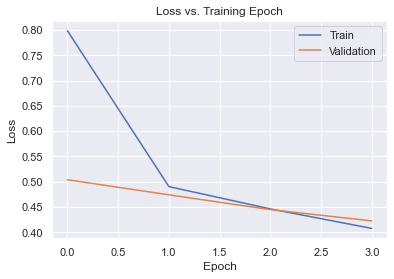

In [46]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

### 3c) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (Target 2: 'Edema')
#### Dropout = 0.35, l1_reg = 0.00025, l2_reg = 0.0025

In [65]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 2

Class Weighting (below) based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [66]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.71
Weight for class 1: 1.67


In [67]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [68]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=147, val=32


In [69]:
model_2 = load_model('models_baby2/model_11.04-0.7043.hdf5')

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [70]:
model_2.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.00025,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [71]:
initial_learning_rate = 0.000125
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model_2.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [72]:
model_2.optimizer.get_config()['learning_rate']

0.000125

In [73]:
# Decrement learning rate every epoch
def lr_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    a = 0.6
    return lr * a

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.6, patience=1, mode='max', min_delta=0.002, min_lr=1e-7)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model_2.optimizer.get_config()['learning_rate'], 7))))

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=2, restore_best_weights=True)

history_2 = model_2.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=6, verbose=1, validation_data=val_iterator, 
                     callbacks=[
                         auc,
                         eval_callback,
                         reduce_lr,
                         lr_callback,
                         early_stopping,
                         keras.callbacks.ModelCheckpoint(
                             'models_final/model_2.{epoch:02d}-{auc:.4f}.hdf5',
                             save_best_only=False)
                     ])

Epoch 1/6
Learning Rate: 0.000125
147/147 [==============================] - 9223s 63s/step - loss: 1.9267 - val_loss: 0.9206

val-roc-auc: 0.7438                                                                                                    

Epoch 2/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9127s 62s/step - loss: 0.8740 - val_loss: 0.8065

val-roc-auc: 0.7453                                                                                                    

Epoch 3/6
Learning Rate: 7.500000356230885e-05
147/147 [==============================] - 9129s 62s/step - loss: 0.7777 - val_loss: 0.7549

val-roc-auc: 0.7517                                                                                                    

Epoch 4/6
Learning Rate: 7.500000356230885e-05
147/147 [==============================] - 9093s 62s/step - loss: 0.7271 - val_loss: 0.7387

val-roc-auc: 0.7355                                                                       

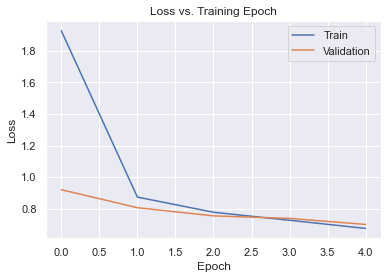

In [74]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

### 3d) VGG16 + 3 Dense Layers (128, 64, 1, dropout) w/ trainable layer_5 (Target 3: 'Pleural Effusion')
#### Dropout = 0.40, l1_reg = 0.00001, l2_reg = 0.0001

In [75]:
## Targets: 'Atelectasis'=0, 'Cardiomegaly'=1, 'Edema'=2, 'Pleaural Effusion'=3

target = 3

Class Weighting (below) based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [76]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
#    The sum of the weights of all examples stays the same.

# weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / np.sum(y_train[:, target])) * (y_train.shape[0]/2.0)

# weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_0 = (1 / (y_train.shape[0] - np.sum(y_train[:, target]))) * (y_train.shape[0]/2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.78
Weight for class 1: 1.41


In [77]:
## FOR REPEATABILITY (must re-run this before EVERY model training run):

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(1)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(2)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(2)

In [78]:
batch_size = 256

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

# prepare iterators to scale images
train_iterator = datagen.flow(X_train, y_train[:, target], batch_size=batch_size)

val_iterator = datagen.flow(X_val, y_val[:, target], batch_size=batch_size)

print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=147, val=32


In [79]:
model_3 = load_model('models_baby3/model_6.08-0.7715.hdf5')

model_3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 273, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 273, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3670144   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256

In [80]:
model_3.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.00025,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [81]:
initial_learning_rate = 0.000125
adam_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                 beta_1=0.9, 
                                 beta_2=0.999, 
                                 epsilon=1e-07, 
                                 amsgrad=False)

model_3.compile(
    loss='binary_crossentropy',
    optimizer=adam_opt
)

In [82]:
model_3.optimizer.get_config()['learning_rate']

0.000125

In [ ]:
# Decrement learning rate every epoch
def lr_decay(epoch, lr):
    print('Previous lr: {}'.format(lr))
    a = 0.6
    return lr * a

# This AUC will be calculated at the end of each epoch on the validation set and be used for early stopping
auc = ROAUCMetrics(val_data=(X_val, y_val[:, target]))

eval_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: logs.update({'auc': auc.val_aucs[-1]})) 

reduce_lr = ReduceLROnPlateau(monitor='auc', factor=0.6, patience=1, mode='max', min_delta=0.002, min_lr=1e-7)

lr_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('Learning Rate: {}'.format(round(model_3.optimizer.get_config()['learning_rate'], 7))))

early_stopping = EarlyStopping(monitor='auc', mode='max', patience=2, restore_best_weights=True)

history_3 = model_3.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=6, verbose=1, validation_data=val_iterator, 
                     callbacks=[
                         auc,
                         eval_callback,
                         reduce_lr,
                         lr_callback,
                         early_stopping,
                         keras.callbacks.ModelCheckpoint(
                             'models_final/model_3.{epoch:02d}-{auc:.4f}.hdf5',
                             save_best_only=False)
                     ])

Epoch 1/6
Learning Rate: 0.000125
147/147 [==============================] - 9085s 62s/step - loss: 0.5900 - val_loss: 0.5137

val-roc-auc: 0.7849                                                                                                    

Epoch 2/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9170s 62s/step - loss: 0.5069 - val_loss: 0.4993

val-roc-auc: 0.8142                                                                                                    

Epoch 3/6
Learning Rate: 0.0001250000059371814
147/147 [==============================] - 9048s 62s/step - loss: 0.4871 - val_loss: 0.4850

val-roc-auc: 0.7582                                                                                                    

Epoch 4/6
Learning Rate: 7.500000356230885e-05
147/147 [==============================] - 9110s 62s/step - loss: 0.4560 - val_loss: 0.4807


Epoch 4 val-roc-auc: 0.7947  (Notebook glitch prevented printout, but it was calculated and triggered Early Stopping here...)

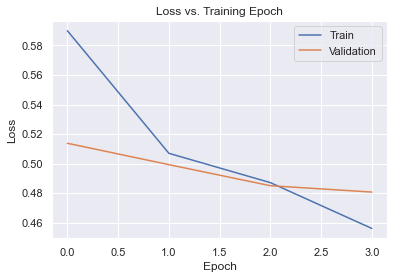

In [86]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

plt.title('Loss vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation']);

# 4) Load in the held-out Test set and check final model performance

In [87]:
X_test = np.load('data2/X_test.dat')
y_test = np.load('data2/y_test.dat')

print(X_test.shape)
print(y_test.shape)

(8030, 224, 273, 1)
(8030, 4)


In [88]:
y_test = y_test.astype(float)

## 4a) Multilabel Model

In [90]:
model_all = load_model('models_3/model_4.01-0.50.hdf5')

y_pred_all = model_all.predict(X_test)

roc_auc_score(y_test, y_pred_all, average=None)

array([0.65154372, 0.72505005, 0.72544385, 0.76416017])

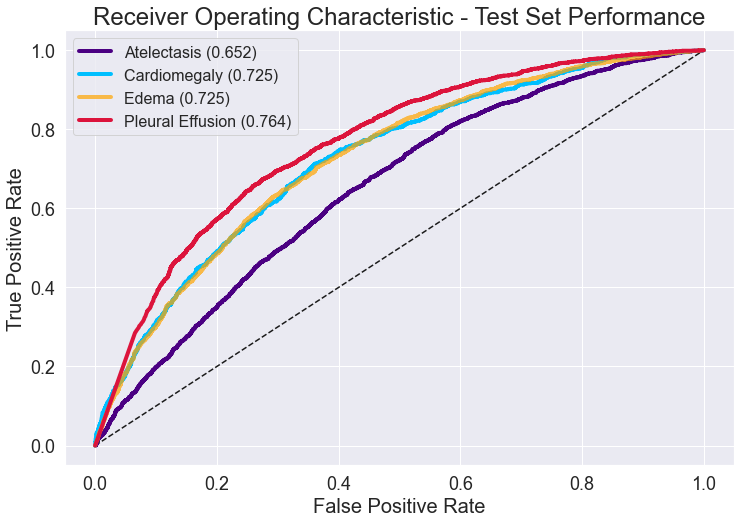

In [144]:
fpr_all_1 , tpr_all_1, thresholds1 = roc_curve(y_test[:, 0], y_pred_all[:, 0])

fpr_all_2 , tpr_all_2, thresholds2 = roc_curve(y_test[:, 1], y_pred_all[:, 1])

fpr_all_3 , tpr_all_3, thresholds3 = roc_curve(y_test[:, 2], y_pred_all[:, 2])

fpr_all_4 , tpr_all_4, thresholds4 = roc_curve(y_test[:, 3], y_pred_all[:, 3])

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_all_1, tpr_all_1, label= 'Atelectasis ({})'.format(round(auc(fpr_all_1, tpr_all_1), 3)), linewidth=4, color='indigo')
plt.plot(fpr_all_2, tpr_all_2, label= 'Cardiomegaly ({})'.format(round(auc(fpr_all_2, tpr_all_2), 3)), linewidth=4, color='deepskyblue') # linestyle='--', 
plt.plot(fpr_all_3, tpr_all_3, label= 'Edema ({})'.format(round(auc(fpr_all_3, tpr_all_3), 3)), linewidth=4, alpha=0.7, color='orange'), # linestyle='-.', 
plt.plot(fpr_all_4, tpr_all_4, label= 'Pleural Effusion ({})'.format(round(auc(fpr_all_4, tpr_all_4), 3)), linewidth=4, color='crimson') # linestyle=':', 
plt.legend(fontsize=16)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic - Test Set Performance', fontsize=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

## 4b) Single-Label Model (target = 0: 'Atelectasis')

In [94]:
model_0 = load_model('models_final/model_0.03-0.6785.hdf5')

y_pred_0 = model_0.predict(X_test)

roc_auc_score(y_test[:, 0], y_pred_0)

0.687761778265025

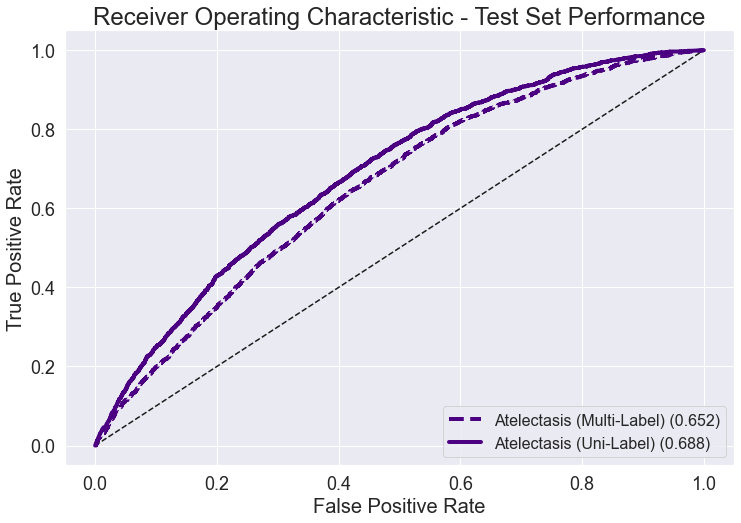

In [155]:
fpr0 , tpr0, thresholds_uni_0 = roc_curve(y_test[:, 0], y_pred_0)

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_all_1, tpr_all_1, label= 'Atelectasis (Multi-Label) ({})'.format(round(auc(fpr_all_1, tpr_all_1), 3)), linestyle='--', linewidth=4, color='indigo')
plt.plot(fpr0, tpr0, label= 'Atelectasis (Uni-Label) ({})'.format(round(auc(fpr0, tpr0), 3)), linewidth=4, color='indigo')
plt.legend(fontsize=16, loc='lower right')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic - Test Set Performance', fontsize=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

## 4c) Single-Label Model (target = 1: 'Cardiomegaly')

In [95]:
model_1 = load_model('models_final/model_1.02-0.7784.hdf5')

y_pred_1 = model_1.predict(X_test)

roc_auc_score(y_test[:, 1], y_pred_1)

0.7882978826441256

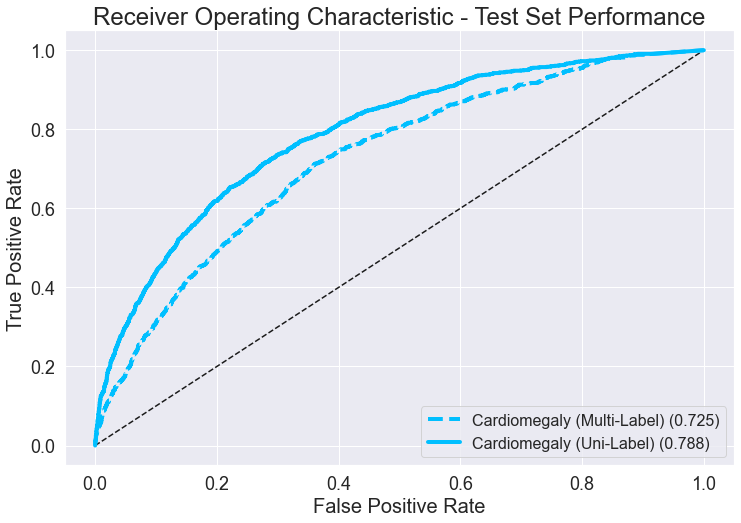

In [154]:
fpr1 , tpr1, thresholds_uni_1 = roc_curve(y_test[:, 1], y_pred_1)

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_all_2, tpr_all_2, label= 'Cardiomegaly (Multi-Label) ({})'.format(round(auc(fpr_all_2, tpr_all_2), 3)), linestyle='--', linewidth=4, color='deepskyblue')
plt.plot(fpr1, tpr1, label= 'Cardiomegaly (Uni-Label) ({})'.format(round(auc(fpr1, tpr1), 3)), linewidth=4, color='deepskyblue')
plt.legend(fontsize=16, loc='lower right')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic - Test Set Performance', fontsize=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

## 4d) Single-Label Model (target = 2: 'Edema')

In [96]:
model_2 = load_model('models_final/model_2.03-0.7517.hdf5')

y_pred_2 = model_2.predict(X_test)

roc_auc_score(y_test[:, 2], y_pred_2)

0.7525947830890118

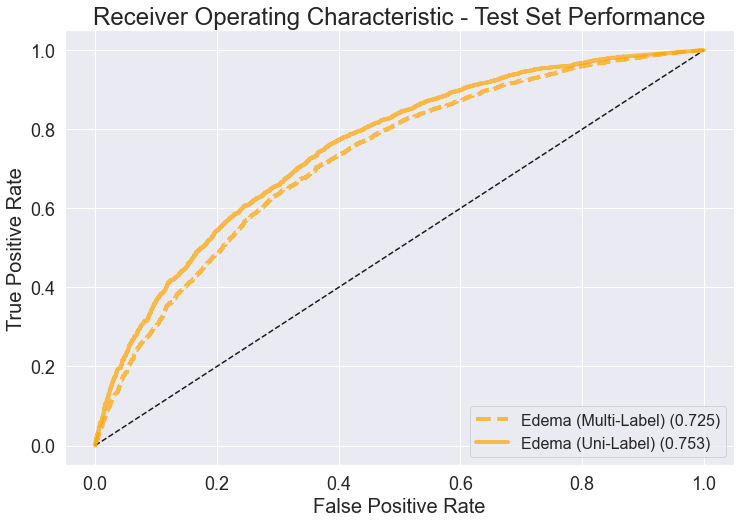

In [153]:
fpr2 , tpr2, thresholds_uni_2 = roc_curve(y_test[:, 2], y_pred_2)

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_all_3, tpr_all_3, label= 'Edema (Multi-Label) ({})'.format(round(auc(fpr_all_3, tpr_all_3), 3)), linestyle='--', linewidth=4, alpha=0.7, color='orange')
plt.plot(fpr2, tpr2, label= 'Edema (Uni-Label) ({})'.format(round(auc(fpr2, tpr2), 3)), linewidth=4, alpha=0.7, color='orange')
plt.legend(fontsize=16, loc='lower right')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic - Test Set Performance', fontsize=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

## 4e) Single-Label Model (target = 3: 'Pleural Effusion')

In [97]:
model_3 = load_model('models_final/model_3.02-0.8142.hdf5')

y_pred_3 = model_3.predict(X_test)

roc_auc_score(y_test[:, 3], y_pred_3)

0.8182744438250729

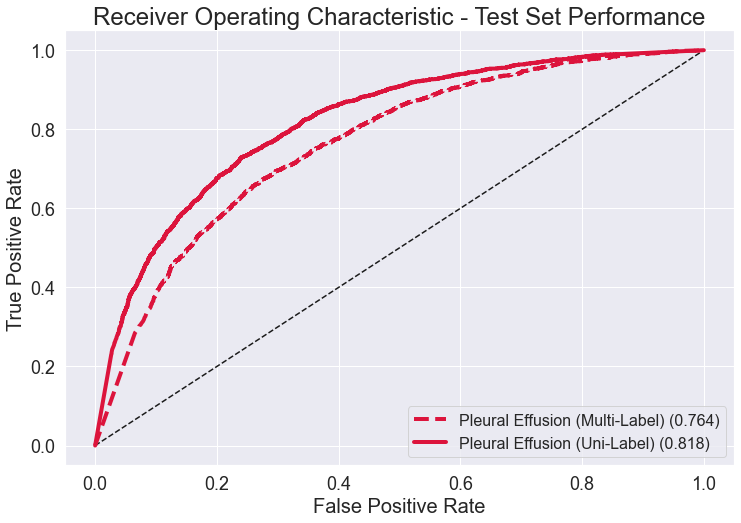

In [152]:
fpr3 , tpr3, thresholds_uni_3 = roc_curve(y_test[:, 3], y_pred_3)

plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_all_4, tpr_all_4, label= 'Pleural Effusion (Multi-Label) ({})'.format(round(auc(fpr_all_4, tpr_all_4), 3)), linestyle='--', linewidth=4, color='crimson')
plt.plot(fpr3, tpr3, label= 'Pleural Effusion (Uni-Label) ({})'.format(round(auc(fpr3, tpr3), 3)), linewidth=4, color='crimson')
plt.legend(fontsize=16, loc='lower right')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic - Test Set Performance', fontsize=24)
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()